# <b>Introduction<b>

In this project, I classify Yelp round-10 review datasets. The reviews contain a lot of metadata that can be mined and used to infer meaning, business attributes, and sentiment. For simplicity, I classify the review comments into two class: either as positive or negative. Reviews that have star higher than three are regarded as positive while the reviews with star less than or equal to 3 are negative. Therefore, the problem is a supervised learning. To build and train the model, I first tokenize the text and convert them to sequences. Each review comment is limited to 50 words. As a result, short texts less than 50 words are padded with zeros, and long ones are truncated. After processing the review comments, I trained three model in three different ways: 

<li> Model-1: In this model, a neural network with LSTM and a single embedding layer were used. 
<li> Model-2: In Model-1, an extra 1D convolutional layer has been added on top of LSTM layer to reduce the training time.
<li> Model-3:  In this model, I use the same network architecture as Model-2, but use the pre-trained glove 100 dimension word embeddings as initial input.

Since there are about 1.6 million input comments, it takes a while to train the models. To reduce the training time step, I limit the training epoch to three. After three epochs, it is evident that Model-2 is better regarding both training time and validation accuracy.

## <b>Project Outline <b>

In this project I will cover the follwouings :

<li> Download data from yelp and process them
<li> Build neural network with LSTM
<li> Build neural network with LSTM and CNN
<li> Use pre-trained GloVe word embeddings
<li> Word Embeddings from Word2Vec

## <b>Import libraries<b>

In [1]:
import numpy as np
import pandas as pd

# Other
import re
import string

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

## Plot
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import matplotlib as plt

## <b> Data Processing<b>

In [2]:
df = pd.read_csv('./data/debate.csv', encoding = 'iso-8859-1')

In [3]:
df.head(20)

,Line,Speaker,Text,Date
0,1,Holt,Good evening from Hofstra University in Hempst...,9/26/16
1,2,Audience,(APPLAUSE),9/26/16
2,3,Clinton,"How are you, Donald?",9/26/16
3,4,Audience,(APPLAUSE),9/26/16
4,5,Holt,Good luck to you.,9/26/16
5,6,Audience,(APPLAUSE),9/26/16
6,7,Holt,"Well, I don't expect us to cover all the issue...",9/26/16
7,8,Clinton,"Well, thank you, Lester, and thanks to Hofstra...",9/26/16
8,9,Clinton,I also want to see more companies do profit-sh...,9/26/16
9,10,Holt,"Secretary Clinton, thank you. Mr. Trump, the s...",9/26/16


In [4]:
df.shape

(1389, 4)

In [5]:
df.isnull().sum(axis = 0)

Line       0
Speaker    0
Text       0
Date       0
dtype: int64

In [39]:
df_new = df[(df.Speaker == 'Clinton') | (df.Speaker == 'Trump')]

In [40]:
df_new.isnull().sum(axis = 0)


Line       0
Speaker    0
Text       0
Date       0
dtype: int64

In [41]:
df_new.describe(include = 'all')

,Line,Speaker,Text,Date
count,598.000000,598,598,598
unique,NaN,2,586,3
top,NaN,Trump,Wrong.,9/26/16
freq,NaN,355,7,228
mean,169.513378,NaN,NaN,NaN
std,97.704623,NaN,NaN,NaN
min,3.000000,NaN,NaN,NaN
25%,84.250000,NaN,NaN,NaN
50%,165.000000,NaN,NaN,NaN
75%,250.750000,NaN,NaN,NaN


In [42]:
df_new.head()

,Line,Speaker,Text,Date
2,3,Clinton,"How are you, Donald?",9/26/16
7,8,Clinton,"Well, thank you, Lester, and thanks to Hofstra for hosting us. The central question in this election is really what kind of country we want to be and what kind of future we'll build together. Today is my granddaughter's second birthday, so I think about this a lot. First, we have to build an economy that works for everyone, not just those at the top. That means we need new jobs, good jobs, with rising incomes. I want us to invest in you. I want us to invest in your future. That means jobs in...",9/26/16
8,9,Clinton,"I also want to see more companies do profit-sharing. If you help create the profits, you should be able to share in them, not just the executives at the top. And I want us to do more to support people who are struggling to balance family and work. I've heard from so many of you about the difficult choices you face and the stresses that you're under. So let's have paid family leave, earned sick days. Let's be sure we have affordable child care and debt-free college. How are we going to do it?...",9/26/16
10,11,Trump,"Thank you, Lester. Our jobs are fleeing the country. They're going to Mexico. They're going to many other countries. You look at what China is doing to our country in terms of making our product. They're devaluing their currency, and there's nobody in our government to fight them. And we have a very good fight. And we have a winning fight. Because they're using our country as a piggy bank to rebuild China, and many other countries are doing the same thing. So we're losing our good jobs, so m...",9/26/16
11,12,Trump,"We cannot let it happen. Under my plan, I'll be reducing taxes tremendously, from 35 percent to 15 percent for companies, small and big businesses. That's going to be a job creator like we haven't seen since Ronald Reagan. It's going to be a beautiful thing to watch. Companies will come. They will build. They will expand. New companies will start. And I look very, very much forward to doing it. We have to renegotiate our trade deals, and we have to stop these countries from stealing our comp...",9/26/16


### Tokenize text data

Because of the computational expenses, I use the top 20000 unique words. First, tokenize the comments then convert those into sequences. I keep 50 words to limit the number of words in each comment. 

In [43]:
def clean_text(text):
    
    ## Remove puncuation
    text = re.sub(r'[^\w\s.?]', ' ', text)
    
    # Clean the text)
    text = re.sub(r"\?", ".", text)
    text = re.sub(r"\.\.\.", ".", text)
    text = re.sub(r"\d+\w?", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    
#     text = text.split()
#     stemmer = SnowballStemmer('english')
#     stemmed_words = [stemmer.stem(word) for word in text]
#     text = " ".join(stemmed_words)

    return text

In [44]:
df_new['processed_text'] = df_new['Text'].map(lambda x: clean_text(x))

/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [45]:
pd.set_option('display.max_colwidth', 500)
df_new.head(20)

,Line,Speaker,Text,Date,processed_text
2,3,Clinton,"How are you, Donald?",9/26/16,donald.
7,8,Clinton,"Well, thank you, Lester, and thanks to Hofstra for hosting us. The central question in this election is really what kind of country we want to be and what kind of future we'll build together. Today is my granddaughter's second birthday, so I think about this a lot. First, we have to build an economy that works for everyone, not just those at the top. That means we need new jobs, good jobs, with rising incomes. I want us to invest in you. I want us to invest in your future. That means jobs in...",9/26/16,well thank lester thanks hofstra hosting us. central question election really kind country want kind future build together. today granddaughter second birthday think lot. first build economy works everyone top. means need new jobs good jobs rising incomes. want invest you. want invest future. means jobs infrastructure advanced manufacturing innovation technology clean renewable energy small business new jobs come small business. also make economy fairer. starts raising national minimum wage ...
8,9,Clinton,"I also want to see more companies do profit-sharing. If you help create the profits, you should be able to share in them, not just the executives at the top. And I want us to do more to support people who are struggling to balance family and work. I've heard from so many of you about the difficult choices you face and the stresses that you're under. So let's have paid family leave, earned sick days. Let's be sure we have affordable child care and debt-free college. How are we going to do it?...",9/26/16,also want see companies profit sharing. help create profits able share executives top. want support people struggling balance family work. heard many difficult choices face stresses under. let paid family leave earned sick days. let sure affordable child care debt free college. going it. going wealthy pay fair share close corporate loopholes. finally tonight stage together donald trump donald good you. going debate talking important issues facing country. judge shoulder immense awesome respo...
10,11,Trump,"Thank you, Lester. Our jobs are fleeing the country. They're going to Mexico. They're going to many other countries. You look at what China is doing to our country in terms of making our product. They're devaluing their currency, and there's nobody in our government to fight them. And we have a very good fight. And we have a winning fight. Because they're using our country as a piggy bank to rebuild China, and many other countries are doing the same thing. So we're losing our good jobs, so m...",9/26/16,thank lester. jobs fleeing country. going mexico. going many countries. look china country terms making product. devaluing currency nobody government fight them. good fight. winning fight. using country piggy bank rebuild china many countries thing. losing good jobs many them. look happening mexico friend mine builds plants said eighth wonder world. building biggest plants anywhere world sophisticated best plants. united states said much. ford leaving. see small car division leaving. thousan...
11,12,Trump,"We cannot let it happen. Under my plan, I'll be reducing taxes tremendously, from 35 percent to 15 percent for companies, small and big businesses. That's going to be a job creator like we haven't seen since Ronald Reagan. It's going to be a beautiful thing to watch. Companies will come. They will build. They will expand. New companies will start. And I look very, very much forward to doing it. We have to renegotiate our trade deals, and we have to stop these countries from stealing our comp...",9/26/16,cannot let happen. plan reducing taxes tremendously percent percent companies small big businesses. going job creator like seen since ronald reagan. going beautiful thing watch. companies come. build. expand. new companies start. look much forward it. renegotiate trade deals stop countries stealing companies jobs.
13,14,

In [56]:
big_text = []
for name, text in zip(df_new.Speaker, df_new.processed_text):
    sents = [x for x in text.split('.') if x]
    if len(sents) > 1:
        for sent in sents:
            big_text.append([name, sent])
df_text = pd.DataFrame(big_text, columns = ['name', 'text'])

In [57]:
df_text.shape

(2980, 2)

### Data modeling for text

In [58]:
import py2neo

In [ ]:
DATA_MODEL = '''
CREATE 
  (`0` :Word ) ,
  (`1` :Word ) ,
  (`3` :Speaker ) ,
  (`0`)-[:`NEXT_WORD` ]->(`1`),
  (`0`)-[:`BELONGS_TO` ]->(`3`),
  (`1`)-[:`BELONGS_TO` ]->(`3`)
'''

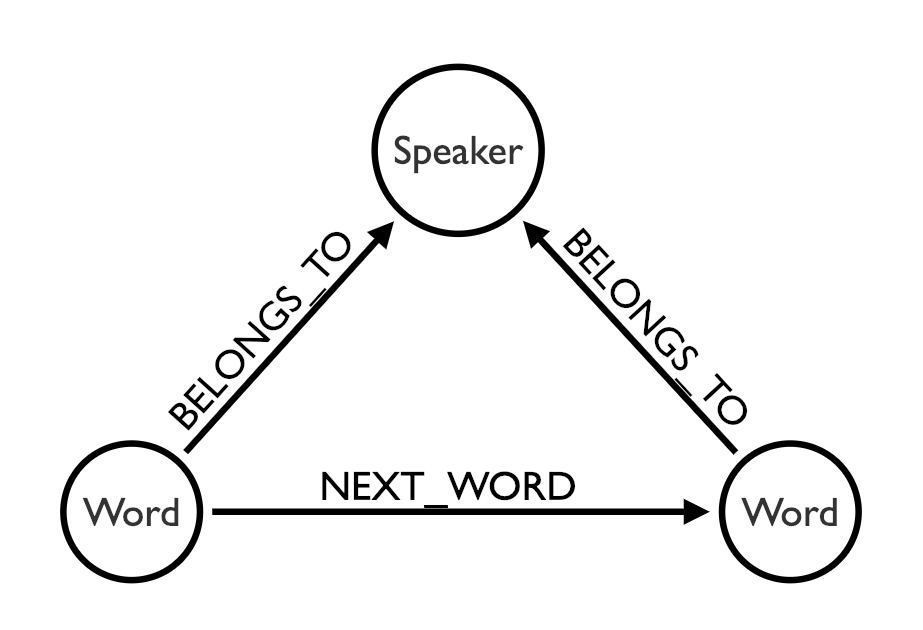

In [55]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "./images/text_model_for_neo4j.png", width = 500, height=300)

### Export Data to Ne04j

## <b>Word Embeddings from Word2Vec<b>

In this subsection, I use word2vec to create word embeddings from the review comments. Word2vec is one algorithm for learning a word embedding from a text corpus.

In [197]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/sabber/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

###  Tokenize the reviews coments. 

In [198]:
df['tokenized'] = df.apply(lambda row : nltk.word_tokenize(row['text']), axis=1)

In [199]:
df.head()

,stars,text,tokenized
0,5,The minute I realized that Conflict was a bloc...,"[The, minute, I, realized, that, Conflict, was..."
2,5,I love Conflict Kitchen. The food is fantasti...,"[I, love, Conflict, Kitchen, ., The, food, is,..."
3,4,Holy moly! I'm addicted!\n\nI first heard of C...,"[Holy, moly, !, I, 'm, addicted, !, I, first, ..."
4,4,"Had some great Persian food, though it was mor...","[Had, some, great, Persian, food, ,, though, i..."
5,4,Yummy food. Good prices. Encourages me to try ...,"[Yummy, food, ., Good, prices, ., Encourages, ..."


### Train word2vec model

In [200]:
model_w2v = Word2Vec(df['tokenized'], size=100)

In [203]:
X = model_w2v[model_w2v.wv.vocab]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



### Plot Word Vectors Using PCA

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [209]:
tsvd = TruncatedSVD(n_components=5, n_iter=10)
result = tsvd.fit_transform(X)

In [210]:
result.shape

(158919, 5)

In [222]:
tsvd_word_list = []
words = list(model_w2v.wv.vocab)
for i, word in enumerate(words):
    tsvd_word_list.append(word)

trace = go.Scatter(
    x = result[0:number_of_words, 0], 
    y = result[0:number_of_words, 1],
    mode = 'markers',
    text= tsvd_word_list[0:number_of_words]
)

layout = dict(title= 'SVD 1 vs SVD 2',
              yaxis = dict(title='SVD 2'),
              xaxis = dict(title='SVD 1'),
              hovermode= 'closest')

fig = dict(data = [trace], layout= layout)
py.iplot(fig)